In [1]:
# Load libs:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from glob import glob
from os.path import dirname, abspath, join, exists

from clearml import Task

from sklearn import linear_model

from amplify.data import DataGenerator, DataSplit

In [2]:
# ClearML Stuff
task = Task.init(project_name="amplify", task_name="predict_power_gen_initial_model")

ClearML Task: created new task id=5b218fddf3274b1a8ceb82c5d6360316
ClearML results page: https://app.clear.ml/projects/f0e0b096252d4c18b9005e580afc5bce/experiments/5b218fddf3274b1a8ceb82c5d6360316/output/log


## Load Data

In [3]:
# DataGenerator - ClearML
xy_data = DataGenerator().load_data()
xy_data.head()

ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Info: Successfully loaded building data!
Info: Successfully loaded weather data!


,temp,pressure,humidity,clouds_all,irradiance,day_of_week,solar,usage
2021-10-19 04:00:00+00:00,10.07,1017.0,66.0,20.0,0.0,2,1.0,11.3
2021-10-19 05:00:00+00:00,9.51,1017.0,70.0,20.0,0.0,2,1.0,13.2
2021-10-19 06:00:00+00:00,9.28,1017.0,71.0,20.0,0.0,2,1.0,12.7
2021-10-19 07:00:00+00:00,9.12,1017.0,72.0,20.0,0.0,2,1.0,17.2
2021-10-19 08:00:00+00:00,9.12,1017.0,73.0,20.0,0.0,2,1.0,17.0


In [4]:
# What is the shape of the data?
print(f"XY Data Shape: {xy_data.shape}")

XY Data Shape: (1994, 8)


In [5]:
# Lets see a few more rows
xy_data.head(20)

,temp,pressure,humidity,clouds_all,irradiance,day_of_week,solar,usage
2021-10-19 04:00:00+00:00,10.07,1017.0,66.0,20.0,0.000000,2,1.0,11.3
2021-10-19 05:00:00+00:00,9.51,1017.0,70.0,20.0,0.000000,2,1.0,13.2
2021-10-19 06:00:00+00:00,9.28,1017.0,71.0,20.0,0.000000,2,1.0,12.7
2021-10-19 07:00:00+00:00,9.12,1017.0,72.0,20.0,0.000000,2,1.0,17.2
2021-10-19 08:00:00+00:00,9.12,1017.0,73.0,20.0,0.000000,2,1.0,17.0
2021-10-19 09:00:00+00:00,8.91,1017.0,75.0,1.0,0.000000,2,1.0,14.2
2021-10-19 10:00:00+00:00,8.61,1018.0,75.0,1.0,0.000000,2,1.0,14.4
2021-10-19 11:00:00+00:00,8.97,1018.0,73.0,1.0,0.000000,2,1.0,14.1
2021-10-19 12:00:00+00:00,9.12,1018.0,75.0,1.0,323.335022,2,11.3,12.5
2021-10-19 13:00:00+00:00,10.96,1019.0,69.0,1.0,680.919505,2,24.9,13.7


In [6]:
# timestamp example
xy_data.index[0]

Timestamp('2021-10-19 04:00:00+0000', tz='UTC', freq='H')

In [7]:
# Data Shape 
# Batch Size of 10
# Series of 7 Days 168
# (B,  S,   H, F) <-X Y-> (B,  S,   H, O)
# (20, 30, 48, 5) <-X Y-> (20, 30, 48, 1)

## Data Processing

```
1. Make xy data into a set of series of shape [N, M, F],
where N = number of examples; M = nubmer of timestamps; F = Number of features
```

```
2. Train-Test-Validation Split. Split off at 0.8, 0.1, 0.1 ratio for now. Shuffle the split.
```

```
3. Seperate x, y from dataset. Remove last column from dataset to extract y.
```

In [8]:
# Data Shape 
# Batch Size of 10
# Series of 7 Days 168
# (B,  S,   H, F) <-X Y-> (B,  S,   H, O)
# (20, 30, 48, 5) <-X Y-> (20, 30, 48, 1)
train_ds, val_ds, test_ds = DataSplit(xy_data).split_data()

In [9]:
# Isolate XY from datasets
x_train, y_solar_train, y_usage_train = (
    train_ds[0].astype("float32"),
    train_ds[1].astype("float32"),
    train_ds[2].astype("float32"),
)  # Training data
x_val, y_solar_val, y_usage_val = (
    val_ds[0].astype("float32"),
    val_ds[1].astype("float32"),
    val_ds[2].astype("float32"),
)  # Validation data
x_test, y_solar_test, y_usage_test = (
    test_ds[0].astype("float32"),
    test_ds[1].astype("float32"),
    test_ds[2].astype("float32"),
)  # Test data


In [10]:
# format data for training...
# [1,2,....] <= was a column
# do we do (n, 1, n timesteps, n features per timestep) (3,4,5 => 2 days)?

### Reviewing Data

In [11]:
# x_train shape
print("x_train shape")
x_train.shape

x_train shape


(519, 48, 6)

In [12]:
# y_train shape
print("y_solar_train shape")
y_solar_train.shape

y_solar_train shape


(519, 48, 1)

## Modeling

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from keras import Input
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.layers import Bidirectional
from keras.layers import TimeDistributed

### Normalize Data

In [14]:
#TODO: Move to model pipeline
# Normalize X_train data
norm_layer = tf.keras.layers.Normalization(axis=-1)
norm_layer.adapt(x_train)

2022-01-29 16:15:24.585911: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-29 16:15:24.854858: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [23]:
# Testing out this normalization
x_train_norm = norm_layer(x_train)
x_val_norm = norm_layer(x_val)

## Simple LSTM

In [32]:
def SimpleLSTM(n_layer=1, n_series_len=48, n_series_ft=6, n_series_out=1, activation_f='tanh'):
    lstm_input = Input(shape=(n_series_len, n_series_ft))
    lstm_layer = LSTM(n_layer, activation=activation_f, return_sequences=True)(lstm_input)
    x = TimeDistributed(Dense(n_series_out))(lstm_layer)
    #x = Dense(n_outputs)(lstm_layer)
    model = Model(inputs=lstm_input, outputs=x)
    return model

In [35]:
def SimpleLSTM_UsingSequential(n_layer=1, n_series_len=48, n_series_ft=6, n_series_out=1, activation_f='tanh'):
    model = Sequential()
    model.add(LSTM(n_layer, activation=activation_f, input_shape=(n_series_len, n_series_ft), return_sequences=True))
    model.add(TimeDistributed(Dense(n_series_out)))
    return model

In [36]:
n_layer = 10
n_series_len = 48
n_series_ft = 6
n_series_out = 1        # so actual output shape = [n_series_len, n_series_out]
activation_f='tanh'

In [ ]:
#model = SimpleLSTM(n_layer, n_series_len, n_series_ft, n_series_out, activation_f)

In [37]:
model =  SimpleLSTM_UsingSequential(n_layer, n_series_len, n_series_ft, n_series_out, activation_f)

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 48, 10)            680       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 48, 1)             11        
Total params: 691
Trainable params: 691
Non-trainable params: 0
_________________________________________________________________


In [41]:
#optimizer = keras.optimizers.Adam(learning_rate=0.001)
#model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=optimizer)
#model.compile(tf.optimizers.Adam(learning_rate=0.0003),
#      loss='binary_crossentropy',
#      metrics=['acc'])
model.compile(tf.optimizers.Adam(learning_rate=0.001),
      loss=keras.losses.Huber(),
      metrics=[keras.metrics.RootMeanSquaredError()])

# So, we tried with a fixed learning rate, and this sucks...

In [42]:
history = model.fit(
    x=x_train_norm,
    y=y_solar_train,
    epochs=30,
    batch_size=10,
    validation_data=(x_val_norm, y_solar_val),
    shuffle=False,
)


Epoch 1/30
52/52 [==============================] - 9s 51ms/step - loss: 3.7646 - root_mean_squared_error: 6.9278 - val_loss: 3.3152 - val_root_mean_squared_error: 6.4259
Epoch 2/30
52/52 [==============================] - 2s 33ms/step - loss: 3.6532 - root_mean_squared_error: 6.8698 - val_loss: 3.2331 - val_root_mean_squared_error: 6.3303
Epoch 3/30
52/52 [==============================] - 2s 42ms/step - loss: 3.5789 - root_mean_squared_error: 6.7587 - val_loss: 3.1735 - val_root_mean_squared_error: 6.2272
Epoch 4/30
52/52 [==============================] - 2s 38ms/step - loss: 3.5095 - root_mean_squared_error: 6.6383 - val_loss: 3.1185 - val_root_mean_squared_error: 6.1234
Epoch 5/30
52/52 [==============================] - 2s 42ms/step - loss: 3.4408 - root_mean_squared_error: 6.5167 - val_loss: 3.0652 - val_root_mean_squared_error: 6.0254
Epoch 6/30
52/52 [==============================] - 3s 50ms/step - loss: 3.3651 - root_mean_squared_error: 6.3962 - val_loss: 3.0100 - val_root_m

## Understanding Results

In [46]:
# Run a prediction:
pred_out = model.predict(x_val_norm)
pred_out.shape

(65, 48, 1)

In [59]:
# compare to y shape
y_solar_val.shape

(65, 48, 1)

In [60]:
# lets see a few of these (just showing the final entry)
limited_view = pred_out[:5]
limited_view.shape

(5, 48, 1)

In [61]:
# Comparing to actual values
limited_y = y_solar_val[:5,]
limited_y.shape

(5, 48, 1)

In [63]:
reshape_out = limited_y[0].reshape((limited_y.shape[2], limited_y.shape[1]))
print(reshape_out)

[[10.9  2.6  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1
   1.1  1.1  1.1  1.1  5.4 13.4 25.5 31.1 35.5 25.5 14.9  8.5  0.7  1.1
   1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1
   1.1  5.1  9.2  9.6 10.6 16.7]]


In [72]:
def PrintPredVsY(pred_out, y_gt, num_row, num_ts):
    limited_pred = pred_out[:num_row, -num_ts:]
    limited_y = y_gt[:num_row, -num_ts:]

    for i in range(num_row):
        flatten_row_pred = limited_pred[i].reshape((num_ts))
        flatten_row_y = limited_y[i].reshape((num_ts))
        print(f"--- Row {i} ---")
        print(f"Y_Pred: {np.round(flatten_row_pred, 1)}")
        print(f"Y     : {np.round(flatten_row_y, 1)}")

In [73]:
PrintPredVsY(pred_out, y_solar_val, num_row=10, num_ts=5)

--- Row 0 ---
Y_Pred: [11.4 16.9 17.  14.4 10.2]
Y     : [ 5.1  9.2  9.6 10.6 16.7]
--- Row 1 ---
Y_Pred: [20.3 25.2 26.  25.4 20.9]
Y     : [16.5 24.9 28.6 24.  13. ]
--- Row 2 ---
Y_Pred: [1.1 1.4 1.3 1.  1.1]
Y     : [0.4 0.4 0.4 0.4 0.4]
--- Row 3 ---
Y_Pred: [1.1 1.1 1.1 1.2 1.4]
Y     : [1.1 1.1 1.1 1.1 1.1]
--- Row 4 ---
Y_Pred: [ 2.2  1.8  7.  19.1 24.3]
Y     : [ 1.6  1.6 11.8 15.3 32.1]
--- Row 5 ---
Y_Pred: [16.8 24.8 26.8 26.1 23.5]
Y     : [16.7 19.2 26.9 27.7 23.8]
--- Row 6 ---
Y_Pred: [1.4 1.7 1.7 1.6 1.7]
Y     : [0.7 0.7 0.7 0.7 0.7]
--- Row 7 ---
Y_Pred: [3.6 3.5 3.4 3.4 3. ]
Y     : [3.1 3.1 3.1 3.1 3.1]
--- Row 8 ---
Y_Pred: [1.4 1.3 1.3 1.2 1.2]
Y     : [0.3 0.3 0.3 0.3 0.3]
--- Row 9 ---
Y_Pred: [2.9 3.2 2.7 2.2 1.9]
Y     : [9.5 9.5 9.5 9.5 9.5]


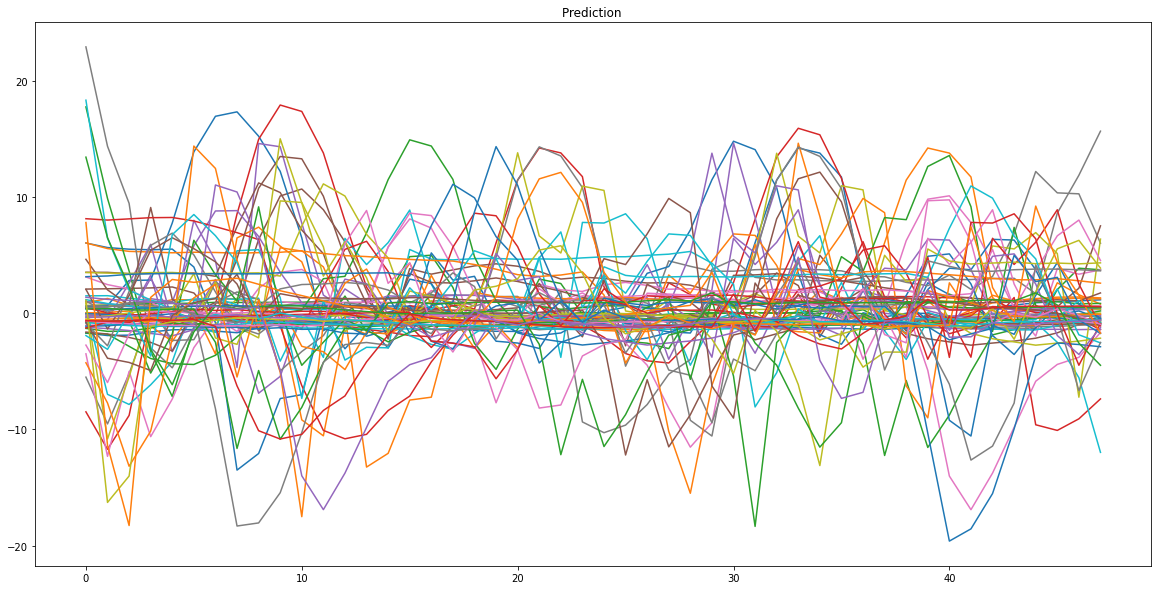

In [75]:
x_test_norm = norm_layer(x_test)
y_solar_preds = model.predict(x_test_norm)
plt.figure(figsize=(20, 10))
plt.title('Prediction ')
for x in range(y_solar_preds.shape[0]):
    #plt.plot(y_solar_preds[x])
    plt.plot(y_solar_test[x] - y_solar_preds[x])

plt.show()

In [76]:
#Helper functions for this:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [127]:
#y_solar_test.shape
#y_solar_test

array([[[ 7.6],
        [ 7.6],
        [ 7.6],
        ...,
        [ 3.1],
        [ 3.1],
        [ 3.1]],

       [[ 2.1],
        [ 2.1],
        [ 2.1],
        ...,
        [ 2.4],
        [ 2.4],
        [ 2.4]],

       [[ 1.6],
        [ 1.6],
        [ 1.6],
        ...,
        [ 1.3],
        [ 1.3],
        [ 1.3]],

       ...,

       [[32. ],
        [32.1],
        [28.4],
        ...,
        [ 2.3],
        [ 5. ],
        [ 7.5]],

       [[ 0.3],
        [ 0.3],
        [ 0.3],
        ...,
        [ 1.5],
        [ 1.5],
        [ 1.5]],

       [[ 2.4],
        [ 2.4],
        [ 2.4],
        ...,
        [ 0.3],
        [ 0.3],
        [ 0.3]]], dtype=float32)

In [122]:
#y_mae = keras.losses.mean_absolute_error(y_solar_test, y_solar_preds)
#y_mae.shape

TensorShape([65, 48])

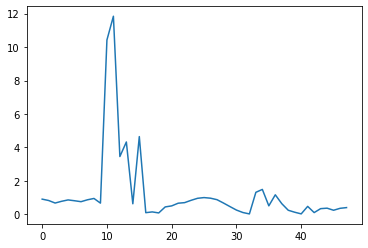

In [124]:
#plt.figure()
#plt.plot(y_mae[1])
#plt.show()

In [140]:
# N = [3, 3 ,1]
x_m = np.array([[1.1, 2, 3], [1.2, 5, 3], [1.3, 5, 3]], np.float32)
x_m = x_m.reshape((3,3,1))
x_m
#y_manual_mae = 100. * np.mean(np.abs((y_solar_test - y_pred) / y_true), axis=-1))

array([[[1.1],
        [2. ],
        [3. ]],

       [[1.2],
        [5. ],
        [3. ]],

       [[1.3],
        [5. ],
        [3. ]]], dtype=float32)

In [145]:
y_manual_mae = np.mean(np.abs((x_m)), axis=0)
y_manual_mae

array([[1.2],
       [4. ],
       [3. ]], dtype=float32)

In [150]:
def calc_mape(y_true, y_pred, axis):
    abs_error = np.abs((y_true - y_pred) / y_true)
    mape = 100. * np.mean(abs_error, axis=axis)
    return mape

def calc_mae(y_true, y_pred, axis):
    abs_error = np.abs(y_true - y_pred)
    mae = np.mean(abs_error, axis=axis)
    return mae

def plot_all_error(y_pred, y_actual):
    plt.figure(figsize=(20, 10))
    plt.title('Prediction Error')
    for x in range(y_pred.shape[0]):
        #plt.plot(y_solar_preds[x])
        plt.plot(y_actual[x] - y_pred[x])

    plt.show()

    plt.title('Prediction Mean Absolute Prediction Error')
    #y_mae = keras.losses.mean_absolute_error(y_actual, y_pred)
    y_mape_0 = calc_mape(y_actual, y_pred, axis=0)
    y_mape_1 = calc_mape(y_actual, y_pred, axis=1)
    plt.plot(y_mape_0)
    plt.plot(y_mape_1)
    plt.ylabel("Percent Error")
    plt.xlabel("Observation/Hour")
    plt.legend(['mape_by_hour', 'mape_by_observation'], loc='upper left')
    plt.show()

    plt.title('Prediction Mean Absolute Percentage Error')
    #y_mape = keras.losses.mean_absolute_percentage_error(y_actual, y_pred)
    y_mae_0 = calc_mae(y_actual, y_pred, axis=0)
    y_mae_1 = calc_mae(y_actual, y_pred, axis=1)
    plt.plot(y_mae_0)
    plt.plot(y_mae_1)
    plt.ylabel("kW")
    plt.xlabel("Observation/Hour")
    plt.legend(['mae_by_hour', 'mae_by_observation'], loc='upper left')
    plt.show()
      

In [96]:
def plot_history(history, metric):
    # This function will plot the model fit process
    print(history.history.keys())
    # summarize history for accuracy
    if metric == "root_mean_squared_error":
        plt.plot(history.history['root_mean_squared_error'])
        plt.plot(history.history['val_root_mean_squared_error'])
        plt.title('model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    elif metric == "mean_absolute_percentage_error":
        plt.plot(history.history["mean_absolute_percentage_error"])
        plt.plot(history.history["val_mean_absolute_percentage_error"])
        plt.title('model MAPE')
        plt.ylabel('MAPE')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    elif metric == "mean_absolute_error":
        plt.plot(history.history["mean_absolute_error"])
        plt.plot(history.history["val_mean_absolute_error"])
        plt.title('model MAE')
        plt.ylabel('MAE')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


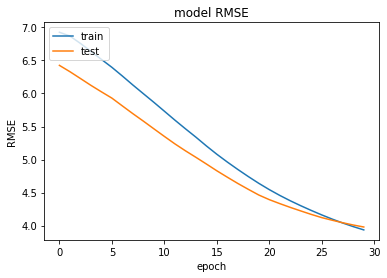

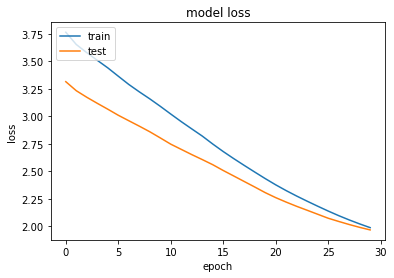

In [80]:
plot_history(history, metric="root_mean_squared_error")

## Improving The Model

### 1: Add LR scheduler

In [81]:
#Try again with this callback
reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

In [82]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(
    x=x_train_norm,
    y=y_solar_train,
    epochs=30,
    batch_size=10,
    validation_data=(x_val_norm, y_solar_val),
    shuffle=False,
    callbacks=[reduce_lr]
)

Epoch 1/30
52/52 [==============================] - 7s 50ms/step - loss: 1.9562 - root_mean_squared_error: 3.8847 - val_loss: 1.9502 - val_root_mean_squared_error: 3.9543
Epoch 2/30
52/52 [==============================] - 2s 37ms/step - loss: 1.9241 - root_mean_squared_error: 3.8380 - val_loss: 1.9331 - val_root_mean_squared_error: 3.9323
Epoch 3/30
52/52 [==============================] - 2s 36ms/step - loss: 1.8994 - root_mean_squared_error: 3.8022 - val_loss: 1.9190 - val_root_mean_squared_error: 3.9151
Epoch 4/30
52/52 [==============================] - 2s 44ms/step - loss: 1.8789 - root_mean_squared_error: 3.7724 - val_loss: 1.9073 - val_root_mean_squared_error: 3.9017
Epoch 5/30
52/52 [==============================] - 2s 39ms/step - loss: 1.8615 - root_mean_squared_error: 3.7474 - val_loss: 1.8969 - val_root_mean_squared_error: 3.8897
Epoch 6/30
52/52 [==============================] - 2s 43ms/step - loss: 1.8467 - root_mean_squared_error: 3.7264 - val_loss: 1.8878 - val_root_m

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error', 'lr'])


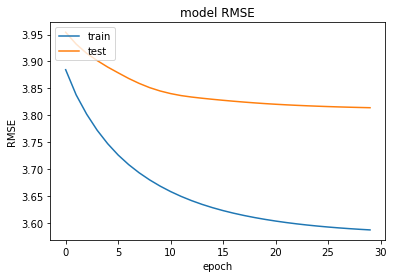

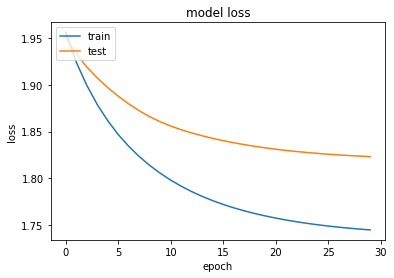

In [83]:
plot_history(history, metric="root_mean_squared_error")

In [85]:
# Prediction:
x_test_norm = norm_layer(x_test)
y_solar_preds = model.predict(x_test_norm)

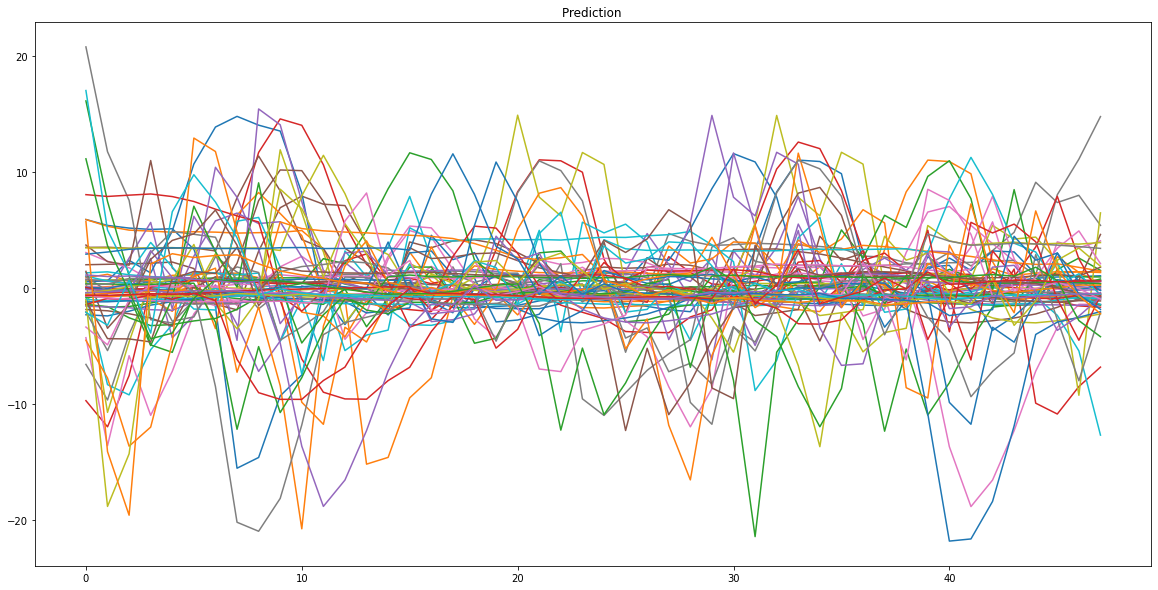

In [86]:
plot_all_error(y_pred=y_solar_preds, y_actual=y_solar_test)

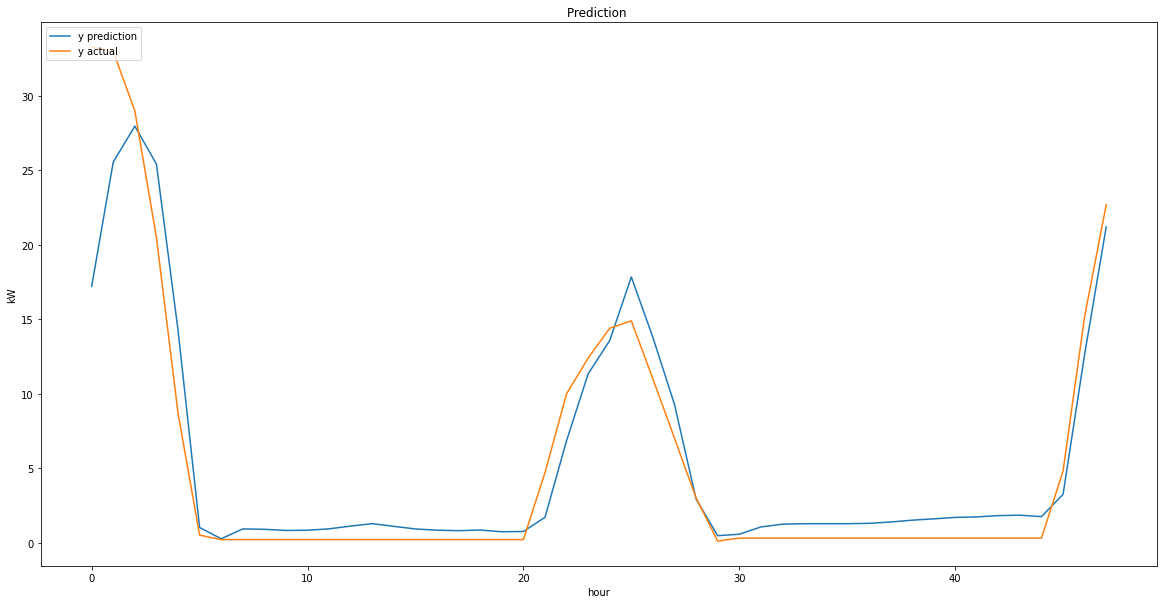

In [94]:
rng = np.random.default_rng(seed=42)
plt.figure(figsize=(20, 10))
plt.title('Prediction ')
x = np.random.default_rng().integers(0,y_solar_preds.shape[0])
plt.plot(y_solar_preds[x])
plt.plot(y_solar_test[x])
plt.ylabel('kW')
plt.xlabel('hour')
plt.legend(['y prediction', 'y actual'], loc='upper left')

plt.show()

In [98]:
def plot_random_comparison(y_pred, y_actual):
    rng = np.random.default_rng(seed=42)
    plt.figure(figsize=(20, 10))
    x = np.random.default_rng().integers(0, y_pred.shape[0])
    plt.title(f"Random Prediction Plot, Test Observation {x}")
    plt.plot(y_pred[x])
    plt.plot(y_actual[x])
    plt.ylabel('kW')
    plt.xlabel('hour')
    plt.legend(['y prediction', 'y actual'], loc='upper left')

    plt.show()

### Improving Metrics:
```
Without understanding our model and how accurate it is, we cannot proceede
```
Possible metrics:
1. MSE
2. RMSE
3. MAE
4. MAEP

```
MAEP
```

In [95]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
history = model.fit(
    x=x_train_norm,
    y=y_solar_train,
    epochs=30,
    batch_size=10,
    validation_data=(x_val_norm, y_solar_val),
    shuffle=False,
    callbacks=[reduce_lr]
)

Epoch 1/30
52/52 [==============================] - 22s 66ms/step - loss: 1.7459 - mean_absolute_percentage_error: 153.9884 - val_loss: 1.8169 - val_mean_absolute_percentage_error: 145.7048
Epoch 2/30
52/52 [==============================] - 2s 43ms/step - loss: 1.7289 - mean_absolute_percentage_error: 151.7864 - val_loss: 1.8060 - val_mean_absolute_percentage_error: 144.8843
Epoch 3/30
52/52 [==============================] - 2s 46ms/step - loss: 1.7160 - mean_absolute_percentage_error: 150.9460 - val_loss: 1.7915 - val_mean_absolute_percentage_error: 144.0429
Epoch 4/30
52/52 [==============================] - 2s 35ms/step - loss: 1.7043 - mean_absolute_percentage_error: 150.2157 - val_loss: 1.7890 - val_mean_absolute_percentage_error: 144.2827
Epoch 5/30
52/52 [==============================] - 2s 43ms/step - loss: 1.6947 - mean_absolute_percentage_error: 149.9595 - val_loss: 1.7767 - val_mean_absolute_percentage_error: 143.8868
Epoch 6/30
52/52 [==============================] - 2s

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error', 'lr'])


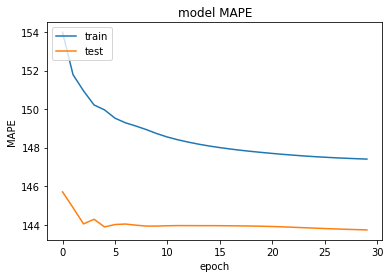

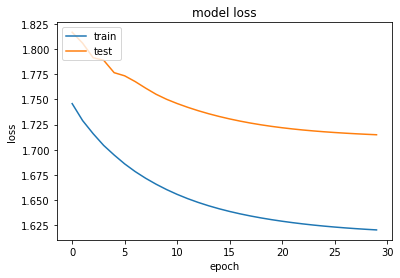

In [97]:
plot_history(history, metric="mean_absolute_percentage_error")

In [99]:
# Prediction:
x_test_norm = norm_layer(x_test)
y_solar_preds = model.predict(x_test_norm)

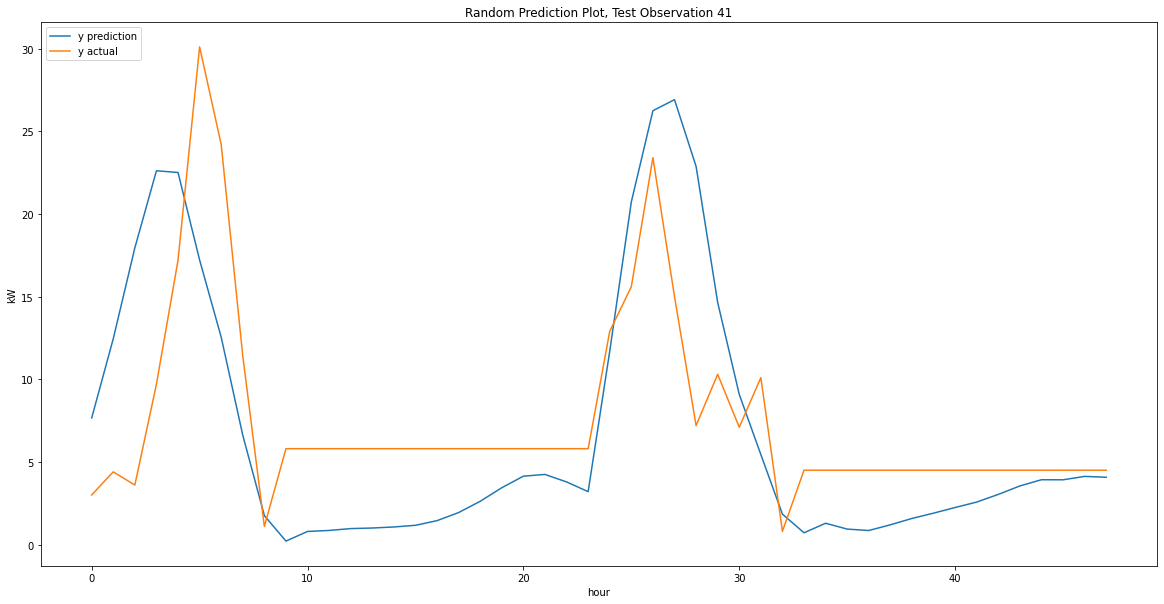

In [108]:
plot_random_comparison(y_solar_preds, y_solar_test)

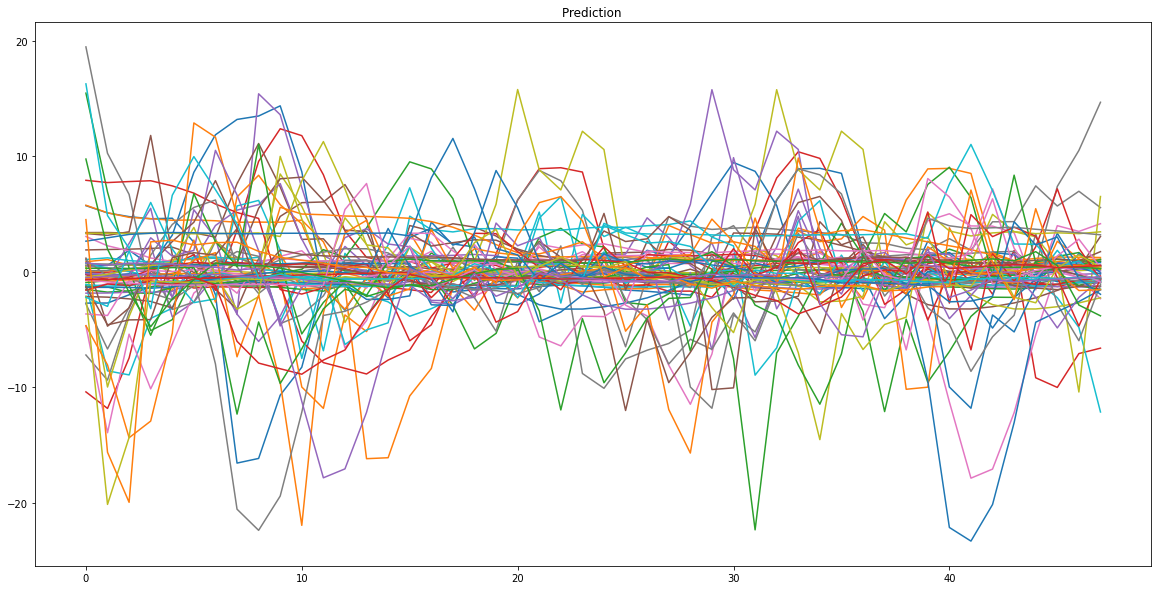

In [111]:
plot_all_error(y_solar_preds, y_solar_test)

This seems to be intuitive enough to understand. I will try now just MAE

```
MAE
```

In [113]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(
    x=x_train_norm,
    y=y_solar_train,
    epochs=30,
    batch_size=10,
    validation_data=(x_val_norm, y_solar_val),
    shuffle=True,
    callbacks=[reduce_lr]
)

Epoch 1/30
52/52 [==============================] - 20s 128ms/step - loss: 1.5387 - mean_absolute_error: 1.9396 - val_loss: 1.6242 - val_mean_absolute_error: 2.0258
Epoch 2/30
52/52 [==============================] - 2s 47ms/step - loss: 1.5257 - mean_absolute_error: 1.9252 - val_loss: 1.6184 - val_mean_absolute_error: 2.0204
Epoch 3/30
52/52 [==============================] - 3s 54ms/step - loss: 1.5211 - mean_absolute_error: 1.9206 - val_loss: 1.6414 - val_mean_absolute_error: 2.0441
Epoch 4/30
52/52 [==============================] - 3s 64ms/step - loss: 1.5207 - mean_absolute_error: 1.9198 - val_loss: 1.6036 - val_mean_absolute_error: 2.0044
Epoch 5/30
52/52 [==============================] - 3s 51ms/step - loss: 1.5109 - mean_absolute_error: 1.9084 - val_loss: 1.5989 - val_mean_absolute_error: 1.9996
Epoch 6/30
52/52 [==============================] - 4s 71ms/step - loss: 1.5041 - mean_absolute_error: 1.9018 - val_loss: 1.5933 - val_mean_absolute_error: 1.9940
Epoch 7/30
52/52 [==

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error', 'lr'])


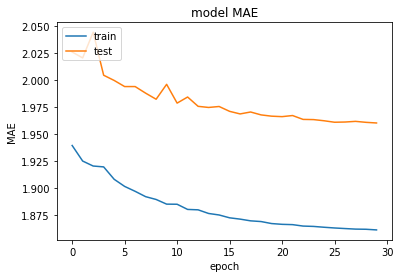

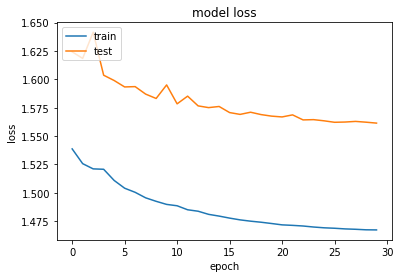

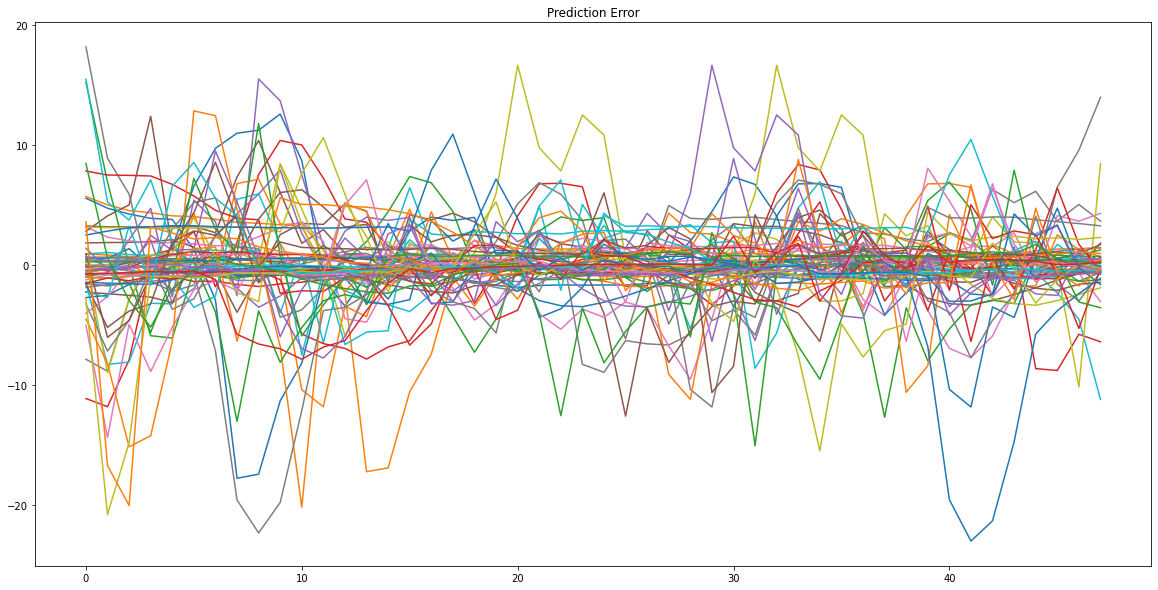

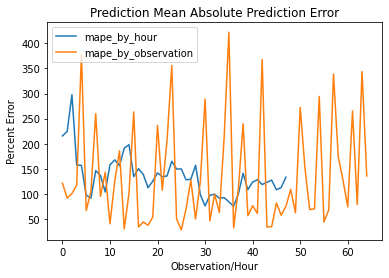

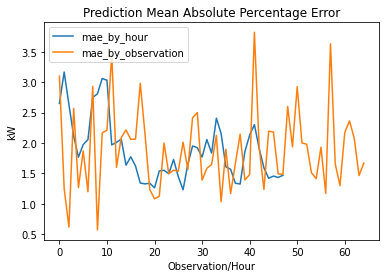

In [151]:
plot_history(history, metric="mean_absolute_error")

# Prediction:
x_test_norm = norm_layer(x_test)
y_solar_preds = model.predict(x_test_norm)
plot_all_error(y_solar_preds, y_solar_test)

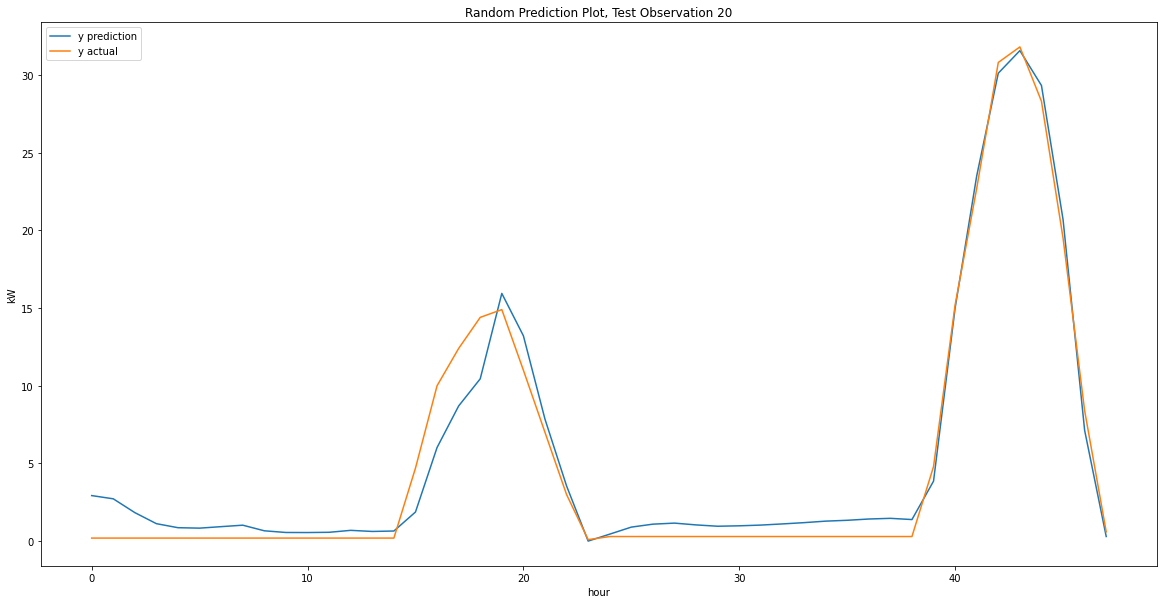

In [155]:
plot_random_comparison(y_solar_preds, y_solar_test)